In [1]:
# load csv

# Read the file to see its structure and check how the tables are separated

import re
import pandas as pd

# def parse_cd_csv(file_path, ):
#     with open(file_path, "r") as file:
#         file_content = file.read()
    
#     # Split the content to find the "Data:" section
#     data_section = file_content.split("Data:\n\n")[1]
    
#     # Split the data section into individual table sections (split by one empty line, accounting for blank lines)
#     tables_raw = re.split(r'\n\n+', data_section.strip())
    
#     # Initialize an empty dictionary to hold the tables
#     tables = {}
    
#     run_df = pd.DataFrame() #columns=['Wavelength', 'Temperature']
#     # Loop through the raw tables and parse them
#     for section in tables_raw:
#         # Adjusting the regex to capture all possible table titles, including CircularDichroism
#         match = re.search(r'(CircularDichroism|HV|Absorbance|Voltage|Count|SE)', section)
#         if match:
#             title = match.group(1)
#             # Split the section into lines
#             lines = section.strip().split('\n')
            
#             # The second line contains the index and column headers (e.g., Wavelength,Temperature)
#             variables = lines[1].split(',')
#             index_column_name = variables[0]
#             assert index_column_name=="Wavelength"
#             variable_column_name = variables[1]

#             # The third line contains the actual column headers (e.g., ,5,10,15,20,...) if Temperature or 0,1,2,3,4.. if Repeat
#             column_headers = lines[2].split(',')

#             # The rest of the lines are data rows
#             data = [line.split(',') for line in lines[3:] if line.strip()]
#             # melt the data
#             # Ensure the number of columns matches, trimming or padding the headers if necessary
#             max_columns = max(len(row) for row in data)
#             adjusted_column_headers = column_headers[:max_columns]
#             if len(adjusted_column_headers) < max_columns:
#                 adjusted_column_headers += [''] * (max_columns - len(adjusted_column_headers))
            
#             # Create a DataFrame
#             df = pd.DataFrame(data, columns=[index_column_name] + adjusted_column_headers[1:])
#             df.set_index(index_and_columns[0], inplace=True)
            
#             # Convert the data to numeric where possible
#             df = df.apply(pd.to_numeric, errors='coerce')
#             df = df.reset_index()  # Wavelength should not be the index
#             df = df.astype(float)  # Set all other columns as float
#             df['Wavelength'] = df['Wavelength'].astype(int)  # Set Wavelength as int


#             # If the table is CircularDichroism, melt the table
#             # if title == "CircularDichroism":
#             df = df.melt(id_vars=["Wavelength"], var_name="Temperature", value_name=title)
#             if run_df.empty:
#                 run_df=df
#             else:
#                 run_df = pd.merge(run_df, df, on=['Wavelength', 'Temperature'])
#     return run_df

import re
import pandas as pd
import re
import pandas as pd

def parse_cd_csv(file_path, temperature_value=None):
    """
    Parses the CD CSV file and dynamically handles 'Temperature' or 'Repeat' columns.
    
    Arguments:
    - file_path: str : Path to the CSV file.
    - temperature_value: float : Required if the structure is based on 'Repeat'. Assigns a constant temperature value for all repeats.
    
    Returns:
    - run_df: DataFrame : Combined and parsed DataFrame from the CSV.
    """
    with open(file_path, "r") as file:
        file_content = file.read()
    
    # Split the content to find the "Data:" section
    data_section = file_content.split("Data:\n\n")[1]
    
    # Split the data section into individual table sections (split by one empty line, accounting for blank lines)
    tables_raw = re.split(r'\n\n+', data_section.strip())
    
    # Initialize an empty DataFrame to hold the processed data
    run_df = pd.DataFrame()
    
    # Loop through the raw tables and parse them
    for section in tables_raw:
        # Adjusting the regex to capture all possible table titles, including CircularDichroism
        match = re.search(r'(CircularDichroism|HV|Absorbance|Voltage|Count|SE)', section)
        if match:
            title = match.group(1)
            # Split the section into lines
            lines = section.strip().split('\n')
            
            # The second line contains the index and column headers (e.g., Wavelength,Temperature or Wavelength,Repeat)
            variables = lines[1].split(',')
            index_column_name = variables[0]
            assert index_column_name == "Wavelength", "The first column must be 'Wavelength'."
            variable_column_name = variables[1]  # Could be Temperature or Repeat
            
            # The third line contains the actual column headers (e.g., ,5,10,15,20,... if Temperature or 0,1,2,3,4.. if Repeat)
            column_headers = lines[2].split(',')

            # The rest of the lines are data rows
            data = [line.split(',') for line in lines[3:] if line.strip()]
            
            # Ensure the number of columns matches, trimming or padding the headers if necessary
            max_columns = max(len(row) for row in data)
            adjusted_column_headers = column_headers[:max_columns]
            if len(adjusted_column_headers) < max_columns:
                adjusted_column_headers += [''] * (max_columns - len(adjusted_column_headers))
            
            # Create a DataFrame from the data
            df = pd.DataFrame(data, columns=[index_column_name] + adjusted_column_headers[1:])
            
            # Convert the data to numeric where possible
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.reset_index(drop=True)  # Ensure no index from original file
            df['Wavelength'] = df['Wavelength'].astype(int)  # Ensure Wavelength is an integer
            

            # Melt the table to have a long format with "Wavelength", var_name (Temperature/Repeat), and the table title
            df = df.melt(id_vars=["Wavelength"], var_name=variable_column_name, value_name=title)



            # If merging multiple data sections, merge on "Wavelength" and var_name (Temperature or Repeat)
            if run_df.empty:
                run_df = df
            else:
                run_df = pd.merge(run_df, df, on=['Wavelength', variable_column_name], how='outer')
            # Detect whether the structure is Temperature or Repeat
        if "Temperature" == variable_column_name:
            assert temperature_value is None, "temperature_value should not be passed when Temperature column is present."
            var_name = "Temperature"
        else:
            # If Repeat structure, ensure temperature_value is passed
            assert temperature_value is not None, "temperature_value must be provided when using 'Repeat' structure."
            df["Temperature"] = temperature_value  # Assign temperature value to a new Temperature column
            
    return run_df

melt_df = parse_cd_csv(
    "/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_80Cmelt00002.csv"
)
post_melt_df = parse_cd_csv("/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_postmelt00000.csv",5)
post_melt_df

,Wavelength,Repeat,CircularDichroism,Temperature,HV,Absorbance,Voltage,Count,SE
0,280,0,0.562020,5,245.575,0.028644,8.06414,10000,0.095569
1,279,0,0.642424,5,245.575,0.029305,8.03380,10000,0.095721
2,278,0,0.660523,5,245.575,0.027003,8.03605,10000,0.079906
3,277,0,0.633973,5,245.575,0.029146,7.99234,10000,0.090648
4,276,0,0.440982,5,245.575,0.031977,7.93755,10000,0.094461
...,...,...,...,...,...,...,...,...,...
399,184,3,31.933300,5,431.625,1.626020,8.04797,10000,0.483656
400,183,3,28.488900,5,454.590,1.735060,8.06628,10000,0.568174
401,182,3,26.993500,5,493.988,1.906190,8.02808,10000,0.796221
402,181,3,22.633000,5,564.545,2.169520,7.90226,10000,0.934408


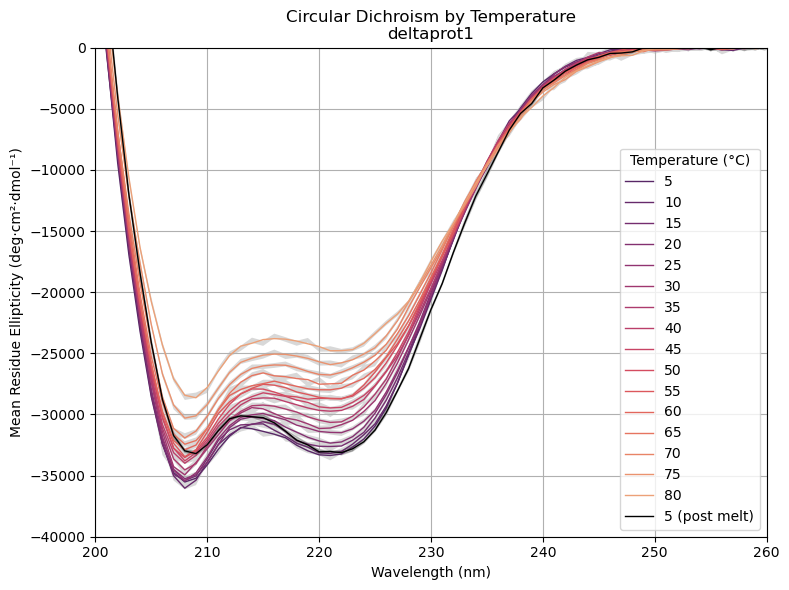

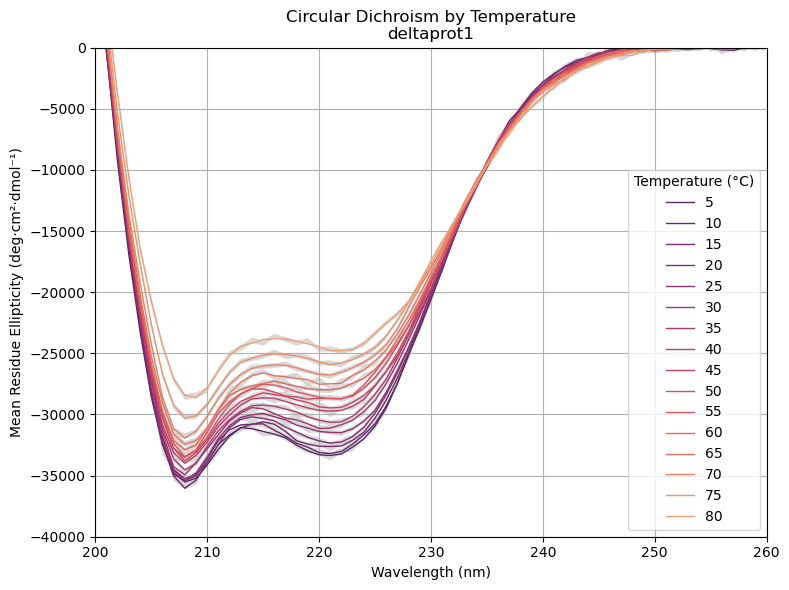

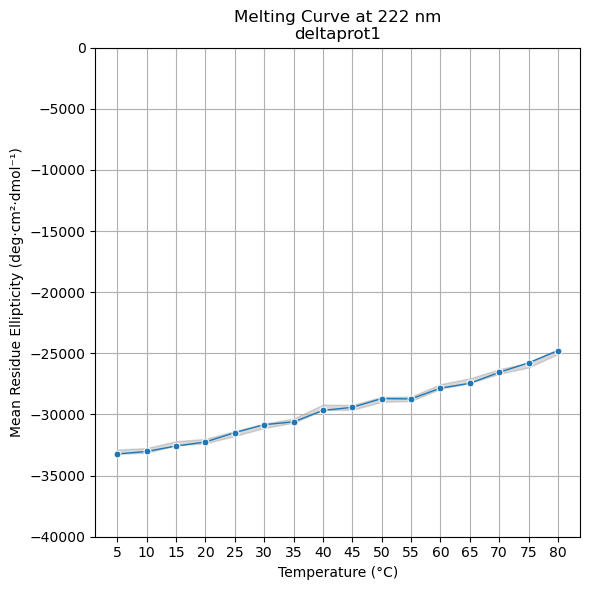

In [4]:
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter

# Set seaborn color palette to 'flare_r'


def get_mean_residue_ellipticity(protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    # Convert Path Length from mm to cm and Protein Concentration from µM to M
    path_length_cm = path_length_mm / 10  # 1 cm = 10 mm
    concentration_M = protein_concentration_uM * 1e-6  # Convert µM to M
    # Calculate MRE multiplication factor
    return 1 / (10 * path_length_cm * num_residues * concentration_M)

# def smooth_cd_data(cd_data, column_name='CircularDichroism', weight_col='Weight', window_size=2):
#     cd_data[weight_col] = 1 / (cd_data['SE'] + 0.0001)  # Weight to avoid division by zero
#     smoothed = np.convolve(cd_data[column_name] * cd_data[weight_col], np.ones(window_size) / window_size, mode='same')
#     weight_sum = np.convolve(cd_data[weight_col], np.ones(window_size) / window_size, mode='same')
#     return smoothed / weight_sum
# from scipy.signal import savgol_filter

def smooth_cd_data(cd_data, column_name='CircularDichroism', window_length=5, polyorder=2):
    """
    Smooth the CD data using the Savitzky-Golay filter.

    Parameters:
    - cd_data: DataFrame containing the CD data.
    - column_name: Name of the column to smooth.
    - window_length: The length of the filter window (i.e., the number of coefficients). Must be a positive odd integer.
    - polyorder: The order of the polynomial used to fit the samples. Must be less than window_length.

    Returns:
    - Smoothed data as a NumPy array.
    """
    # Ensure window_length is odd and less than or equal to the size of the data
    if window_length % 2 == 0:
        window_length += 1
    if window_length > len(cd_data):
        window_length = len(cd_data) - (len(cd_data) % 2 == 0)

    y = cd_data[column_name].values
    smoothed = savgol_filter(y, window_length=window_length, polyorder=polyorder, mode='interp')
    return smoothed

def prepare_cd_data(cd_data, protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    mre_factor = get_mean_residue_ellipticity(protein_concentration_uM, path_length_mm, num_residues)
    cd_data['Smoothed_CD'] = smooth_cd_data(cd_data, column_name='CircularDichroism')
    cd_data['MRE_deg_cm2_dmol'] = cd_data['CircularDichroism'] * mre_factor
    cd_data['Smoothed_MRE_deg_cm2_dmol'] = cd_data['Smoothed_CD'] * mre_factor
    cd_data['SE_MRE_deg_cm2_dmol'] = cd_data['SE'] * mre_factor
    return cd_data


# def plot_cd_melt(cd_filtered, label_suffix='', line_width=1):
#     # Use Seaborn's built-in error plotting
#     sns.lineplot(
#         data=cd_filtered,
#         x='Wavelength',
#         y='Smoothed_MRE_deg_cm2_dmol',
#         hue='Temperature',
#         palette='flare_r',  # Automatically handles color mapping for temperatures
#         linewidth=line_width,
#         legend='full',
#     )
    
#     # Use fill_between to plot the error manually
#     plt.fill_between(
#         cd_filtered['Wavelength'],
#         cd_filtered['MRE_deg_cm2_dmol'] - cd_filtered['SE_MRE_deg_cm2_dmol'],
#         cd_filtered['MRE_deg_cm2_dmol'] + cd_filtered['SE_MRE_deg_cm2_dmol'],
#         alpha=0.3,
#         color="grey",
#         edgecolor=None
#     )
def plot_cd_melt(cd_filtered, label_suffix='', line_width=1):
    sns.lineplot(
        data=cd_filtered,
        x='Wavelength',
        y='Smoothed_MRE_deg_cm2_dmol',
        hue='Temperature',
        palette='flare_r',
        linewidth=line_width,
        legend='full',
    )
    # Plotting the standard error as a shaded area (optional)
    plt.fill_between(
        cd_filtered['Wavelength'],
        cd_filtered['MRE_deg_cm2_dmol'] - cd_filtered['SE_MRE_deg_cm2_dmol'],
        cd_filtered['MRE_deg_cm2_dmol'] + cd_filtered['SE_MRE_deg_cm2_dmol'],
        alpha=0.3,
        color="grey",
        edgecolor=None
    )

def plot_cd_melt_data(cd_data, sample_name, overlay_cd_data=None, overlay_label="Overlay",
                      title="Circular Dichroism by Temperature", save_dir="."):
    # Prepare CD data
    cd_data = prepare_cd_data(cd_data)

    # Set limits for the plot
    x_limits = (200, 260)
    y_limits = (-40000, 1)

    # Filter the data for the relevant wavelength range
    cd_filtered = cd_data[(cd_data['Wavelength'] >= x_limits[0]) & (cd_data['Wavelength'] <= x_limits[1])]

    # Plot the data
    plt.figure(figsize=(8, 6))
    plot_cd_melt(cd_filtered, line_width=1)  # Use a thinner line

    # Check if there is overlay data to plot
    if overlay_cd_data is not None:
        overlay_cd_data = prepare_cd_data(overlay_cd_data)
        overlay_cd_filtered = overlay_cd_data[(overlay_cd_data['Wavelength'] >= x_limits[0]) & 
                                              (overlay_cd_data['Wavelength'] <= x_limits[1])]
        
        # Overlay the error area for the overlay data
        # plt.fill_between(
        #     overlay_cd_filtered['Wavelength'],
        #     overlay_cd_filtered['MRE_deg_cm2_dmol'] - overlay_cd_filtered['SE_MRE_deg_cm2_dmol'],
        #     overlay_cd_filtered['MRE_deg_cm2_dmol'] + overlay_cd_filtered['SE_MRE_deg_cm2_dmol'],
        #     alpha=0.3,
        #     color='gray',
        #     edgecolor=None
        # )    
        sns.lineplot(
            data=overlay_cd_filtered,
            x='Wavelength',
            y='MRE_deg_cm2_dmol',
            color='black',
            label=f'{overlay_label}',
            linewidth=1,
        )



    # Customize the plot
    title+=f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.grid(True)
    plt.legend(title='Temperature (°C)', loc='best')

    # Save the plot
    filename = f"cd_melts_{sample_name}"
    if overlay_cd_data is not None:
        filename += "_overlay"
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"{filename}.{ext}"), dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

# Example call to plotting function

def plot_melting_curve(cd_data, sample_name, title="Melting Curve at 222 nm", save_dir="."):
    # Prepare data
    cd_data = prepare_cd_data(cd_data)

    # Filter the data for Wavelength = 222 nm
    melting_data = cd_data[cd_data['Wavelength'] == 222.0]

    # Set up the plot for the melting curve
    plt.figure(figsize=(6, 6))
    # Plot the error area using fill_between
    plt.fill_between(melting_data['Temperature'],
                     melting_data['MRE_deg_cm2_dmol'] - melting_data['SE_MRE_deg_cm2_dmol'],
                     melting_data['MRE_deg_cm2_dmol'] + melting_data['SE_MRE_deg_cm2_dmol'],
                     alpha=0.3,edgecolor=None,color='grey')  # Transparency for the shaded error area
    sns.lineplot(data=melting_data, x='Temperature', y='Smoothed_MRE_deg_cm2_dmol', marker='o', linewidth=1, markersize=5, legend=False,)  # Thinner line, smaller markers



    # Customize the plot
    title+=f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Temperature (°C)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.grid(True)
    plt.tight_layout()

    y_limits = (-40000, 1)
    plt.ylim(y_limits)

    # Save the plot
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"melting_curve_{sample_name}.{ext}"), dpi=300, bbox_inches="tight")

    plt.show()

melt_df = parse_cd_csv(
    "/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_80Cmelt00002.csv"
)
post_melt_df = parse_cd_csv("/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_postmelt00000.csv",temperature_value=5)
plot_cd_melt_data(melt_df, sample_name="deltaprot1", overlay_label="5 (post melt)", overlay_cd_data=post_melt_df,save_dir="outputs")
plot_cd_melt_data(melt_df, sample_name="deltaprot1",save_dir="outputs")
plot_melting_curve(melt_df, sample_name="deltaprot1",save_dir="outputs")

In [3]:
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def get_mean_residue_ellipticity(protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    path_length_cm = path_length_mm / 10  # Convert mm to cm
    concentration_M = protein_concentration_uM * 1e-6  # Convert µM to M
    return 1 / (10 * path_length_cm * num_residues * concentration_M)

def interpolate_and_smooth_cd_data(cd_data, column_name='CircularDichroism', new_wavelength_grid=None, window_length=7, polyorder=2):
    """
    Interpolate and smooth the CD data.

    Parameters:
    - cd_data: DataFrame containing the CD data.
    - column_name: Name of the column to smooth.
    - new_wavelength_grid: NumPy array of new wavelength values for interpolation.
    - window_length: The length of the filter window for smoothing.
    - polyorder: The order of the polynomial used to fit the samples.

    Returns:
    - interpolated_wavelengths: The new wavelength grid.
    - smoothed_values: The interpolated and smoothed CD values.
    """
    # Extract original wavelengths and CD values
    wavelengths = cd_data['Wavelength'].values
    cd_values = cd_data[column_name].values

    # If no new wavelength grid is provided, create one
    if new_wavelength_grid is None:
        new_wavelength_grid = np.linspace(wavelengths.min(), wavelengths.max(), num=500)

    # Interpolate the CD data onto the new wavelength grid
    interpolation_function = interp1d(wavelengths, cd_values, kind='cubic')
    interpolated_cd_values = interpolation_function(new_wavelength_grid)

    # Apply Savitzky-Golay filter to the interpolated data
    if window_length % 2 == 0:
        window_length += 1  # Window length must be odd
    if window_length >= len(interpolated_cd_values):
        window_length = len(interpolated_cd_values) - 1
        if window_length % 2 == 0:
            window_length -= 1
    smoothed_cd_values = savgol_filter(interpolated_cd_values, window_length, polyorder)

    return new_wavelength_grid, smoothed_cd_values

def prepare_cd_data(cd_data, protein_concentration_uM=50, path_length_mm=0.5, num_residues=33):
    mre_factor = get_mean_residue_ellipticity(protein_concentration_uM, path_length_mm, num_residues)

    # Interpolate and smooth the CD data
    new_wavelength_grid, smoothed_cd_values = interpolate_and_smooth_cd_data(cd_data, column_name='CircularDichroism')

    # Calculate MRE for original and smoothed data
    cd_data['MRE_deg_cm2_dmol'] = cd_data['CircularDichroism'] * mre_factor
    cd_data['SE_MRE_deg_cm2_dmol'] = cd_data['SE'] * mre_factor

    # Create a new DataFrame for the interpolated and smoothed data
    smoothed_cd_df = pd.DataFrame({
        'Wavelength': new_wavelength_grid,
        'Smoothed_CD': smoothed_cd_values,
        'Smoothed_MRE_deg_cm2_dmol': smoothed_cd_values * mre_factor
    })

    return cd_data, smoothed_cd_df

def plot_cd_melt_data(cd_data, sample_name, overlay_cd_data=None, overlay_label="Overlay",
                      title="Circular Dichroism by Temperature", save_dir="."):
    # Prepare CD data
    cd_data, smoothed_cd_df = prepare_cd_data(cd_data)

    # Set limits for the plot
    x_limits = (200, 260)
    y_limits = (-40000, 1)

    # Filter the data for the relevant wavelength range
    cd_filtered = cd_data[(cd_data['Wavelength'] >= x_limits[0]) & (cd_data['Wavelength'] <= x_limits[1])]
    smoothed_cd_filtered = smoothed_cd_df[(smoothed_cd_df['Wavelength'] >= x_limits[0]) & (smoothed_cd_df['Wavelength'] <= x_limits[1])]

    # Plot the data
    plt.figure(figsize=(8, 6))

    # Plot the smoothed data
    sns.lineplot(
        data=smoothed_cd_filtered,
        x='Wavelength',
        y='Smoothed_MRE_deg_cm2_dmol',
        linewidth=1,
        label=f'{sample_name}'
    )

    # Plot the error bars using the original data
    plt.fill_between(
        cd_filtered['Wavelength'],
        cd_filtered['MRE_deg_cm2_dmol'] - cd_filtered['SE_MRE_deg_cm2_dmol'],
        cd_filtered['MRE_deg_cm2_dmol'] + cd_filtered['SE_MRE_deg_cm2_dmol'],
        alpha=0.3,
        color="grey",
        edgecolor=None
    )

    # Check if there is overlay data to plot
    if overlay_cd_data is not None:
        overlay_cd_data, overlay_smoothed_cd_df = prepare_cd_data(overlay_cd_data)
        overlay_cd_filtered = overlay_cd_data[(overlay_cd_data['Wavelength'] >= x_limits[0]) & (overlay_cd_data['Wavelength'] <= x_limits[1])]
        overlay_smoothed_cd_filtered = overlay_smoothed_cd_df[(overlay_smoothed_cd_df['Wavelength'] >= x_limits[0]) & (overlay_smoothed_cd_df['Wavelength'] <= x_limits[1])]

        # Plot the smoothed overlay data
        sns.lineplot(
            data=overlay_smoothed_cd_filtered,
            x='Wavelength',
            y='Smoothed_MRE_deg_cm2_dmol',
            color='black',
            label=f'{overlay_label}',
            linewidth=1,
        )

        # Plot the error area for the overlay data using original data
        plt.fill_between(
            overlay_cd_filtered['Wavelength'],
            overlay_cd_filtered['MRE_deg_cm2_dmol'] - overlay_cd_filtered['SE_MRE_deg_cm2_dmol'],
            overlay_cd_filtered['MRE_deg_cm2_dmol'] + overlay_cd_filtered['SE_MRE_deg_cm2_dmol'],
            alpha=0.3,
            color='grey',
            edgecolor=None
        )

    # Customize the plot
    title += f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.grid(True)
    plt.legend(title='Sample', loc='best')

    # Save the plot
    filename = f"cd_melts_{sample_name}"
    if overlay_cd_data is not None:
        filename += "_overlay"
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"{filename}.{ext}"), dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

def plot_melting_curve(cd_data, sample_name, title="Melting Curve at 222 nm", save_dir="."):
    # Prepare data
    cd_data['MRE_deg_cm2_dmol'] = cd_data['CircularDichroism'] * get_mean_residue_ellipticity()
    cd_data['SE_MRE_deg_cm2_dmol'] = cd_data['SE'] * get_mean_residue_ellipticity()

    # Filter the data for Wavelength = 222 nm
    melting_data = cd_data[cd_data['Wavelength'] == 222.0]

    # Set up the plot for the melting curve
    plt.figure(figsize=(6, 6))
    # Plot the error area using fill_between
    plt.fill_between(melting_data['Temperature'],
                     melting_data['MRE_deg_cm2_dmol'] - melting_data['SE_MRE_deg_cm2_dmol'],
                     melting_data['MRE_deg_cm2_dmol'] + melting_data['SE_MRE_deg_cm2_dmol'],
                     alpha=0.3, edgecolor=None)  # Transparency for the shaded error area
    sns.lineplot(data=melting_data, x='Temperature', y='MRE_deg_cm2_dmol', marker='o', linewidth=1, markersize=5, legend=False)  # Thinner line, smaller markers

    # Customize the plot
    title += f"\n{sample_name}"
    plt.title(title)
    plt.xlabel('Temperature (°C)')
    plt.ylabel("Mean Residue Ellipticity (deg·cm²·dmol⁻¹)")
    plt.grid(True)
    plt.tight_layout()

    y_limits = (-40000, 1)
    plt.ylim(y_limits)

    # Save the plot
    for ext in ["png", "svg"]:
        plt.savefig(os.path.join(save_dir, f"melting_curve_{sample_name}.{ext}"), dpi=300, bbox_inches="tight")

    plt.show()
melt_df = parse_cd_csv(
    "/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_80Cmelt00002.csv"
)
post_melt_df = parse_cd_csv("/home/tadas/code/CD_analysis/inputs/deltaprot1_50uM_5C_postmelt00000.csv",temperature_value=5)
plot_cd_melt_data(melt_df, sample_name="deltaprot1", overlay_label="5°C (post melt)", overlay_cd_data=post_melt_df, save_dir="outputs")

# Plot CD melt data without overlay
plot_cd_melt_data(melt_df, sample_name="deltaprot1", save_dir="outputs")

# Plot melting curve
plot_melting_curve(melt_df, sample_name="deltaprot1", save_dir="outputs")

ValueError: Expect x to not have duplicates